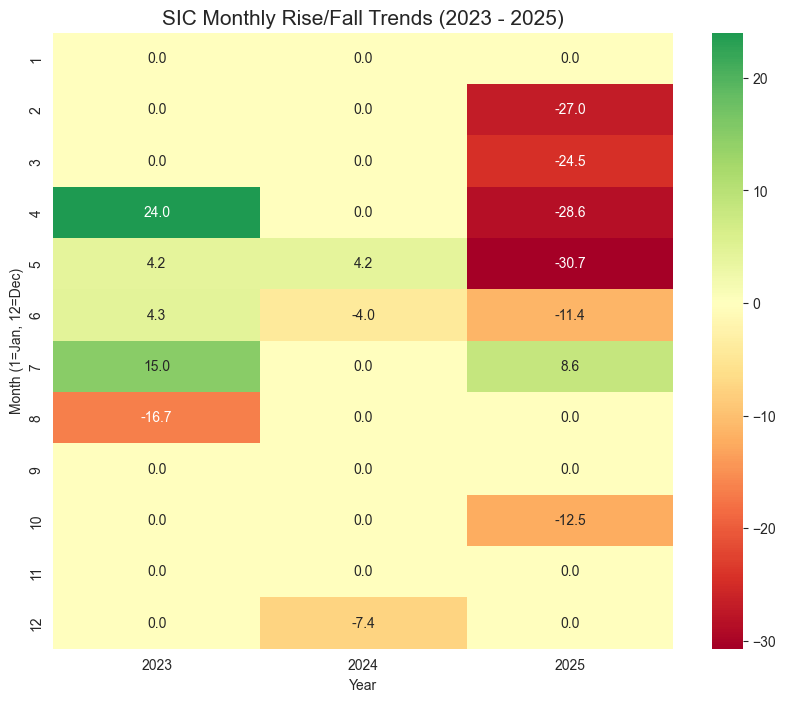

--- Monthly Performance for SIC ---
    Year  Month  Start_Price  End_Price  Monthly_Return_%
0   2023      1         0.31       0.31          0.000000
1   2023      2         0.31       0.31          0.000000
2   2023      3         0.31       0.31          0.000000
3   2023      4         0.25       0.31         24.000000
4   2023      5         0.24       0.25          4.166667
5   2023      6         0.23       0.24          4.347826
6   2023      7         0.20       0.23         15.000000
7   2023      8         0.24       0.20        -16.666667
8   2023      9         0.24       0.24          0.000000
9   2023     10         0.24       0.24          0.000000
10  2023     11         0.24       0.24          0.000000
11  2023     12         0.24       0.24          0.000000
12  2024      1         0.24       0.24          0.000000
13  2024      2         0.24       0.24          0.000000
14  2024      3         0.24       0.24          0.000000
15  2024      4         0.25       0

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and Clean Data
df = pd.read_csv('data/data.csv')
df['Daily Date'] = pd.to_datetime(df['Daily Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Daily Date', 'Share Code'])

# Clean numeric price column
if df['Closing Price - VWAP (GH¢)'].dtype == 'object':
    df['Closing Price - VWAP (GH¢)'] = df['Closing Price - VWAP (GH¢)'].astype(str).str.replace(',', '', regex=False)
    df['Closing Price - VWAP (GH¢)'] = pd.to_numeric(df['Closing Price - VWAP (GH¢)'], errors='coerce')

# 2. Filter for MTNGH and years 2023-2025
# Change 'MTNGH' to any other share code (e.g., 'GCB') to analyze another company
stock_code = 'SIC'
stock_df = df[(df['Share Code'] == stock_code) & (df['Daily Date'].dt.year.isin([2023, 2024, 2025]))].copy()

# Add Year and Month columns for grouping
stock_df['Year'] = stock_df['Daily Date'].dt.year
stock_df['Month'] = stock_df['Daily Date'].dt.month

# 3. Calculate Monthly Performance
# We group by Year and Month, taking the first and last available price of each month
monthly_perf = stock_df.groupby(['Year', 'Month']).agg(
    Start_Price=('Closing Price - VWAP (GH¢)', 'first'),
    End_Price=('Closing Price - VWAP (GH¢)', 'last')
).reset_index()

# Calculate Monthly Return Percentage
monthly_perf['Monthly_Return_%'] = (monthly_perf['End_Price'] - monthly_perf['Start_Price']) / monthly_perf['Start_Price'] * 100

# 4. Create a Pivot Table for the Heatmap
pivot_table = monthly_perf.pivot(index='Month', columns='Year', values='Monthly_Return_%')

# 5. Visualize the "Rise and Fall"
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', center=0, fmt=".1f")

plt.title(f'{stock_code} Monthly Rise/Fall Trends (2023 - 2025)', fontsize=15)
plt.ylabel('Month (1=Jan, 12=Dec)')
plt.xlabel('Year')
plt.show()

# 6. Print the raw data for specific months
print(f"--- Monthly Performance for {stock_code} ---")
print(monthly_perf)

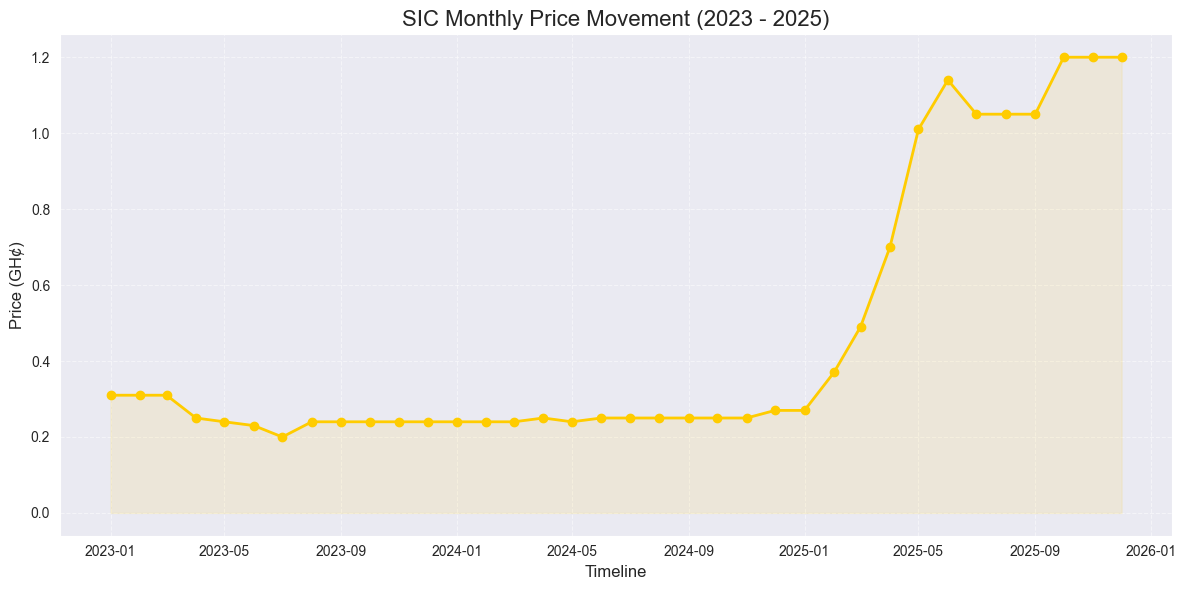

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load and Clean Data
df = pd.read_csv('data/data.csv')
df['Daily Date'] = pd.to_datetime(df['Daily Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Daily Date', 'Share Code'])

# Clean numeric price column
df['Closing Price - VWAP (GH¢)'] = pd.to_numeric(df['Closing Price - VWAP (GH¢)'].astype(str).str.replace(',', ''), errors='coerce')

# 2. Filter for MTNGH (2023-2025)
stock_code = 'SIC'
mtn_df = df[(df['Share Code'] == stock_code) & (df['Daily Date'].dt.year.isin([2023, 2024, 2025]))].copy()
mtn_df = mtn_df.sort_values('Daily Date')

# 3. Get the End-of-Month Price
# This smooths out daily noise to show the monthly trend
mtn_monthly = mtn_df.groupby(mtn_df['Daily Date'].dt.to_period('M')).agg(
    End_of_Month_Price=('Closing Price - VWAP (GH¢)', 'last')
).reset_index()

# Convert Period back to timestamp for plotting
mtn_monthly['Daily Date'] = mtn_monthly['Daily Date'].dt.to_timestamp()

# 4. Create the Simple Line Graph
plt.figure(figsize=(12, 6))
plt.plot(mtn_monthly['Daily Date'], mtn_monthly['End_of_Month_Price'],
         marker='o', linestyle='-', color='#FFCC00', linewidth=2, label='MTNGH Price')

# 5. Styling
plt.title(f'{stock_code} Monthly Price Movement (2023 - 2025)', fontsize=16)
plt.xlabel('Timeline', fontsize=12)
plt.ylabel('Price (GH¢)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.fill_between(mtn_monthly['Daily Date'], mtn_monthly['End_of_Month_Price'], color='#FFCC00', alpha=0.1)

plt.tight_layout()
plt.show()

## Company Fair Value

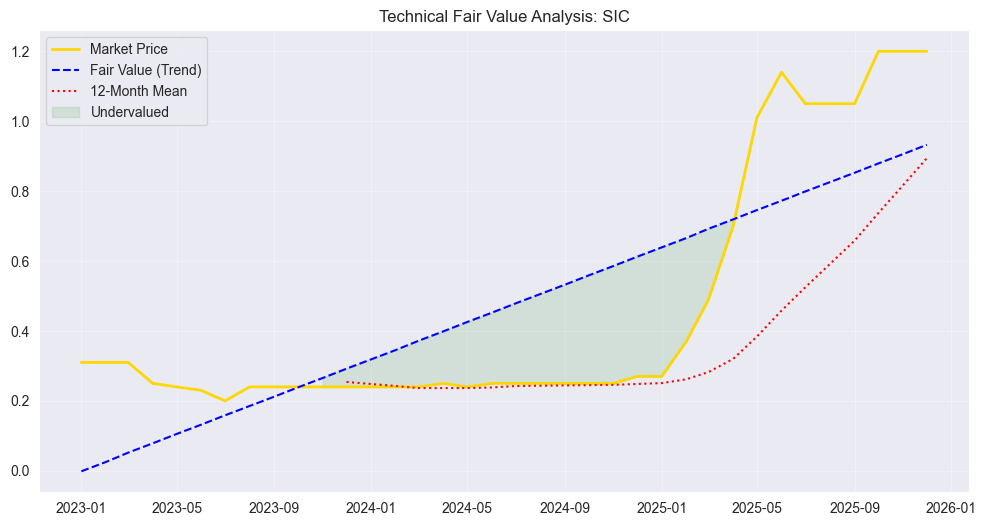

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 1. Prepare Data
df = pd.read_csv('data/data.csv')
df['Daily Date'] = pd.to_datetime(df['Daily Date'], dayfirst=True, errors='coerce')
df['Price'] = pd.to_numeric(df['Closing Price - VWAP (GH¢)'].astype(str).str.replace(',', ''), errors='coerce')

# Filter for MTNGH (2023-2025)
stock_code = 'SIC'
stock_df = df[(df['Share Code'] == stock_code) & (df['Daily Date'].dt.year.isin([2023, 2024, 2025]))].copy()
stock_df = stock_df.sort_values('Daily Date').groupby(stock_df['Daily Date'].dt.to_period('M')).agg({'Price': 'last'}).reset_index()
stock_df['Timestamp'] = stock_df['Daily Date'].dt.to_timestamp()

# 2. Calculate Technical Fair Value (Trend Line)
X = np.arange(len(stock_df)).reshape(-1, 1)
y = stock_df['Price'].values.reshape(-1, 1)
model = LinearRegression().fit(X, y)
stock_df['Fair_Value_Trend'] = model.predict(X)

# 3. Calculate 12-Month Moving Average
stock_df['12m_Average'] = stock_df['Price'].rolling(window=12).mean()

# 4. Plotting
plt.figure(figsize=(12, 6))
plt.plot(stock_df['Timestamp'], stock_df['Price'], label='Market Price', color='gold', linewidth=2)
plt.plot(stock_df['Timestamp'], stock_df['Fair_Value_Trend'], label='Fair Value (Trend)', color='blue', linestyle='--')
plt.plot(stock_df['Timestamp'], stock_df['12m_Average'], label='12-Month Mean', color='red', linestyle=':')

# Highlight Zones
plt.fill_between(stock_df['Timestamp'], stock_df['Price'], stock_df['Fair_Value_Trend'],
                 where=(stock_df['Price'] < stock_df['Fair_Value_Trend']), color='green', alpha=0.1, label='Undervalued')

plt.title(f'Technical Fair Value Analysis: {stock_code}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()